In [1]:
# import library as lib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns
import warnings

from imblearn.over_sampling import SMOTE

from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier

sns.set(style='ticks', palette='RdYlGn', font_scale=1.7, rc={'figure.figsize':(15,15)})
# warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

Using TensorFlow backend.


---
Following our [Exploratory Data Analysis](./EDA.ipynb), let's dive in further in this analysis:
# Setup

In [2]:
df = pd.read_csv("./data/fake_job_postings.csv",index_col='job_id')
df.columns = df.columns.str.title()

Because we've identified the False Negative to be the errors with the highest cost and because we prefer to use a ROC_AUC score (as well as the ROC curve which has the benefit to help us fine-tune the chosen final model), we've decided to swap the values in the 'fraudulent' column. This modification means the model will now predict if a job post is legitimate and it will allow us to use the ROC curve to minimise the False Positives (when an offer is flagged as legit by the model but actually is fraudulent):

In [3]:
df['Fraudulent'].replace([0,1], [1,0], inplace=True)

## Addressing the missing information
As identified in the EDA, there is quite a lot of missing data in this dataset. We have decided to address the missing information in the different columns by replacing the lack of information by `NA`. Instead of using the `Other` or `Unspecified` values available in several columns, this will allow us to spot when no effort was made to provide the information:

01. title:               No missing data
02. location:            NA
03. department:          NA
04. salary_range:        NA
05. company_profile:     NA
06. description:         NA
07. requirements:        NA
08. benefits:            NA
09. telecommuting:       No missing data
10. has_company_logo:    No missing data
11. has_questions:       No missing data
12. employment_type:     NA
13. required_experience: NA
14. required_education:  NA
15. industry:            NA
16. function:            NA
17. fraudulent:          No missing data

In [4]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)

 Some job offers have contact details or an external URL. Could this be linked to fraudulent activity? Could this improve our model's performance?

In [5]:
# turn into a function: use dict (columnName:textToSearch, list(dictinput.keys())[0]:list(dictinput.values())[0])
df = df.assign(HasEMAIL=0, HasPHONE=0, HasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['HasURL'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#PHONE_')!=-1:
            df['HasPHONE'][i] = 1
    for i in range(1,len(df[column])):
        if df[column][i].find('#EMAIL_')!=-1:
            df['HasEMAIL'][i] = 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## Text cleaning
Some job offers have been written in other alphabets, such as Russian, Thai or Greek. But because those job offers were flagged as legitimate and because we wouldn't be able to understand those offers fully (not speaking the language), we are going to remove them from our dataset.

In [6]:
index_non_latin = []
for column in df.columns[4:8]:
        index_non_latin.append(df[df[column].str.find('α')!=-1].index)
        index_non_latin.append(df[df[column].str.find('и')!=-1].index)
        index_non_latin.append(df[df[column].str.find('แ')!=-1].index)
        index_non_latin.append(df[df['Location'].str.find('HK')!=-1].index)
        index_non_latin.append(df[df['Location'].str.find('KR')!=-1].index)

In [7]:
for i in range(1,len(index_non_latin)):
    index_non_latin[0] = index_non_latin[0].append(index_non_latin[i])

In [8]:
index_non_latin = sorted(set(list(index_non_latin[0])))

In [9]:
print('Amount of job ads that are removed from the dataset (1 is for legitimate ads, 0 for fraudulent ones):')
df[df.index.isin(index_non_latin)]['Fraudulent'].value_counts()

Amount of job ads that are removed from the dataset (1 is for legitimate ads, 0 for fraudulent ones):


1    167
Name: Fraudulent, dtype: int64

In [10]:
df = df[df.index.isin(index_non_latin)==False]
df.reset_index(inplace=True)
print(f"After the preprocessing, we are left with {len(df)} job ads: {len(df[df['Fraudulent']==1])} are legitimate and {len(df[df['Fraudulent']==0])} are fraudulent.")

After the preprocessing, we are left with 17713 job ads: 16847 are legitimate and 866 are fraudulent.


## Text pre-processing

In [11]:
for column in df.columns[5:9]:
    df[column].replace('([A-Z][a-z]|[A-Z] )', r' \1', regex=True, inplace=True)
    df[column].replace('(#URL\w+|#PHONE\w+|#EMAIL\w+)', ' ', regex=True, inplace=True)
    df[column].replace('(\\W|\\d)', ' ', regex=True, inplace=True)
    df[column].replace(r'\b\w{1,3}\b', ' ', regex=True, inplace=True)
    df[column].replace('\ +', ' ', regex=True, inplace=True)

In [12]:
# for column in df.columns[5:9]:
#     for i in range(1, len(df[column])):
#         if re.search(r'[^\x00-\x7F]+',df[column][i])!= None:
#             print(re.search(r'[^\x00-\x7F]+',df[column][i]), df['job_id'][i])

Let's see if any clear pattern can already be identified:

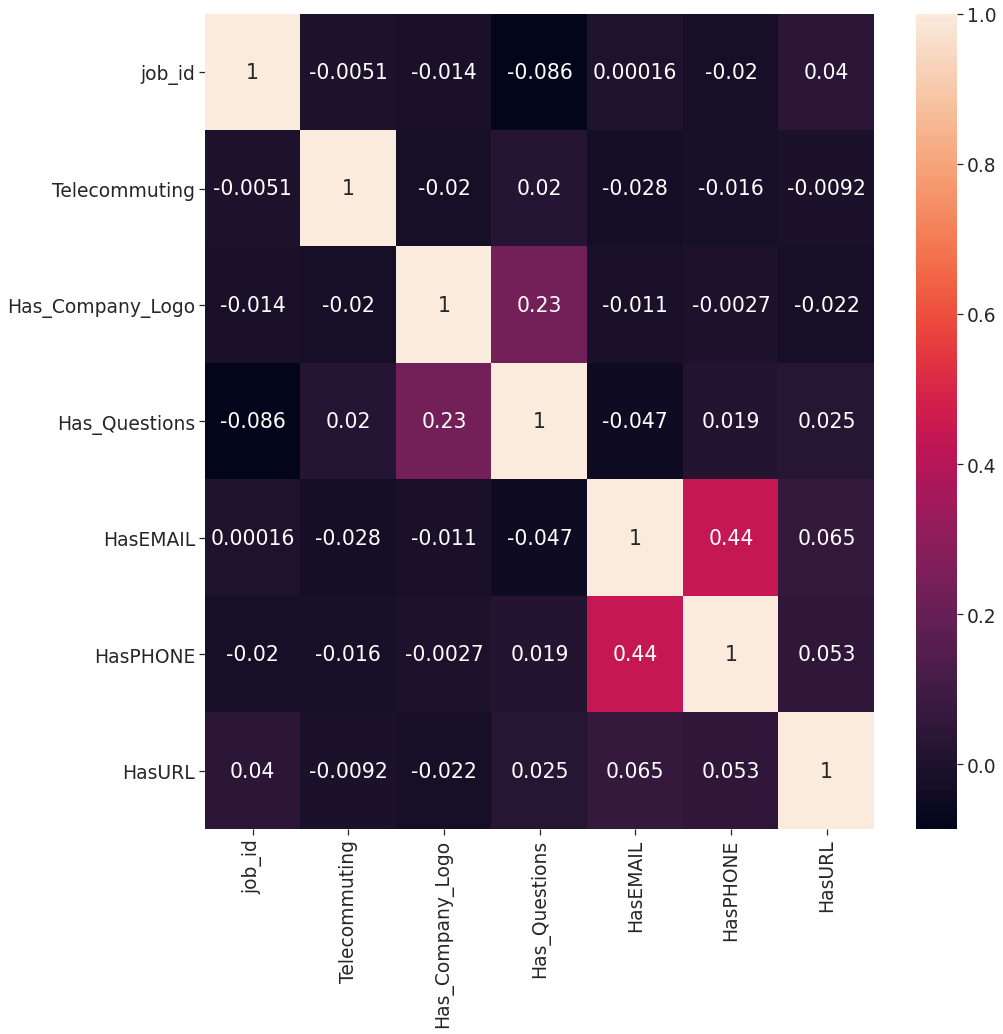

In [13]:
sns.heatmap(df.drop(columns=['Fraudulent']).corr(), annot=True);

No multicollinearity issues with those binary variables

## Information loss
Some information is too complex to deal with (e.g. `'title'` has 11,231 unique values over the 17,713 job offers in this dataset), or has too many missing values (`'salary_range'` has 14,925 missing values over the 17,713 in this dataset). Either way, they would marginally improve the results of our analysis so, we are going to remove those columns from our dataset.

In [14]:
df.drop(columns=['Title', 'Location', 'Department', 'Salary_Range'], inplace=True)

# Dataset formatting
## Numerise the categorical data

In [15]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [16]:
cat_col = ['Employment_Type', 'Required_Experience', 'Required_Education', 'Industry', 'Function']
cat_df = df.loc[:, cat_col]
cat_df = ohe.fit_transform(cat_df)
cat_df = pd.DataFrame(cat_df, columns=ohe.get_feature_names(input_features=cat_col))
df.drop(columns=cat_col, inplace=True)

## TF-IDF computation on the text data

In [17]:
vect_comp = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)
vect_desc = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)
vect_req = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)
vect_ben = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english', max_features=5000)

In [18]:
text_col = ['Company_Profile', 'Description', 'Requirements', 'Benefits']
text_df = df.loc[:, text_col]

In [19]:
company_profile = vect_comp.fit_transform(text_df[text_col[0]])
description = vect_desc.fit_transform(text_df[text_col[1]])
requirements = vect_req.fit_transform(text_df[text_col[2]])
benefits = vect_ben.fit_transform(text_df[text_col[3]])

In [20]:
company_profile_df = pd.DataFrame(company_profile.todense(), columns=vect_comp.get_feature_names())
description_df = pd.DataFrame(description.todense(), columns=vect_desc.get_feature_names())
requirements_df = pd.DataFrame(requirements.todense(), columns=vect_req.get_feature_names())
benefits_df = pd.DataFrame(benefits.todense(), columns=vect_ben.get_feature_names())
text_df = pd.concat([company_profile_df, description_df, requirements_df, benefits_df], axis=1)

In [21]:
df = pd.merge(df.drop(columns=text_col),text_df, left_index=True, right_index=True)

# Undersampling
There are 866 fraudulent job posts. Let us sample 866 non-fraudulent posts to obtain a balanced dataset.

In [22]:
# df_legit = df[df['Fraudulent'] == 1].sample(len(df[df['Fraudulent'] == 0]))
# df = pd.concat([legit_df, df[df['Fraudulent'] == 0]], ignore_index=True)

All of the models trained after undersampling (the NN was not trained) showed overfitting. The test scores were always significantly higher than the train. The most plausible reason for this is the lack of data.

# Train Test Split

In [23]:
labels = df['Fraudulent']
features = df.drop(columns=['Fraudulent'])

In [24]:
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            random_state=666
                                                                           )

In [25]:
print(len(features_train), len(features_test))

13284 4429


In [26]:
len(features_train) + len(features_test)

17713

# Addressing the class imbalance
As class imbalance will only matter during the training step, SMOTE will only be applied to to train dataset.

In [27]:
# SMOTE doesn't work on text, it needs to be changed to TF-IDF
sm = SMOTE(random_state=666, n_jobs=-1)

In [29]:
X, y = sm.fit_resample(features_train.values, labels_train)

In [30]:
X.shape

(25262, 20007)

In [31]:
y.shape

(25262,)

In [ ]:
# Exporting the train set for faster further training
# np.savetxt('X.csv', X, delimiter=',', fmt='%d')
# np.savetxt('y.csv', y, delimiter=',', fmt='%d')

# Gaussian Naive Bayes

In [32]:
gnb = GaussianNB()

In [33]:
gnb.fit(X, y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [34]:
labels_train_pred = gnb.predict_proba(X)

In [35]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred[:,1])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

AUC train dataset: 0.9469198176399278


In [36]:
pickle.dump(gnb, open('./models/gnb.pkl','wb'))

# Multinomial Naive Bayes

In [37]:
mnb = MultinomialNB(alpha=0.31)
# alpha value has been determined during the last paragraph,
# then the code has been run from here to update the results

In [38]:
mnb.fit(X, y)

MultinomialNB(alpha=0.31, class_prior=None, fit_prior=True)

In [39]:
labels_train_pred = mnb.predict_proba(X)

In [40]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred[:,1])
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

AUC train dataset: 0.9916713488668365


In [41]:
pickle.dump(mnb, open('./models/mnb.pkl','wb'))

# Random Forest

In [42]:
rfc = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=666)

In [43]:
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=666, verbose=0,
                       warm_start=False)

In [44]:
# Graph of the RF features in order of importance
# features = feat_train.columns
# importances = rfc.feature_importances_
# indices = np.argsort(importances)

# plt.barh(range(len(indices)),importances[indices], align='center');
# plt.yticks(range(len(indices)), [features[i] for i in indices]);

In [45]:
labels_train_pred = rfc.predict(X)

In [46]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred)
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

AUC train dataset: 1.0


In [47]:
pickle.dump(rfc, open('./models/rfc.pkl','wb'))

## XGBoost

In [48]:
xgb = XGBClassifier()

In [ ]:
xgb.fit(X, y)

In [ ]:
labels_train_pred = xgb.predict(X)

In [ ]:
fpr, tpr, thresholds = roc_curve(y, labels_train_pred)
print('AUC train dataset: {}'.format(auc(fpr, tpr)))

In [ ]:
pickle.dump(xgb, open('./models/xgb.pkl','wb'))

## Neural Network

In [ ]:
# X = np.genfromtxt('X.csv', delimiter=',')
# y = np.genfromtxt('y.csv', delimiter=',')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, MaxPool1D, SpatialDropout1D
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model

In [ ]:
y = pd.get_dummies(y).values

In [ ]:
max_words_in_post = 1000

In [ ]:
# Do we need padding after smote?
padded_X = pad_sequences(X, maxlen = max_words_in_post, padding = 'post')

In [ ]:
model = Sequential()
model.add(Embedding(X.shape[1]+1, max_words_in_post, input_length=X.shape[1], mask_zero=True))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(75, dropout=0.2))
model.add(Dense(y.shape[1], activation='relu'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']
             )
model.summary()

In [ ]:
history = model.fit(X,
                    y,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             min_delta=0.0001,
                                             patience=3,
                                             verbose=1,
                                             mode='min',
                                             restore_best_weights=True
                                             ),
                            #    ModelCheckpoint(filepath='drive/My Drive/Colab Notebooks/Model/Checkpoints/epoch-{epoch:03d}.ckpt', 
                            #                    verbose=1
                            #                    )
                              ]
                   )

########### WIP ###########

# More metrics
Probably create a class and export the code in a `.py` package later on.

In [ ]:
labels_hat(X, gnb)

In [ ]:
precision(X, y, gnb)

In [ ]:
def labels_hat(features, model):
    return model.predict(features)

def precision(labels, features, model):
    label_hat = labels_hat(features, model)
    labels_labels_hat = list(zip(labels, label_hat))
    tp = sum([1 for i in y_yhat if i[0] == 1 and i[1] == 1])
    fp = sum([1 for i in y_yhat if i[0] == 0 and i[1] == 1])
    return tp / float(tp + fp)

def recall(labels, features, model):
    labels_hat = labels_hat(features, model)
    labels_hat = list(zip(labels, labels_hat))
    tp = sum([1 for i in labels_hat if i[0] == 1 and i[1] == 1])
    fn = sum([1 for i in labels_hat if i[0] == 1 and i[1] == 0])
    return tp / float(tp + fn)

def f1score(labels, features, model):
    labels_hat = labels_hat(features, model)
    precision_score = precision(labels, labels_hat)
    recall_score = recall(labels, labels_hat)
    return 2 * ((precision_score * recall_score) / (precision_score + recall_score))

def aucscore(labels, features, model):
    labels_train_pred = model.predict(X)
    fpr, tpr, thresholds = roc_curve(y, labels_train_pred)
    return auc(fpr, tpr)

# Use scikit-learn classification_report(), or
# precision_score(), recall_score(), accuracy_score(), f1_score()?

## Metrics summary table

In [ ]:
models = [gnb, mnb, rfc, xgb]
scores = []
for model in models:
    scores.append({'Precision' : precision(labels, features, model), 'Recall' : recall(labels, features, model), 'F1 score' : f1score(labels, features, model), 'AUC score' : aucscore(labels, features, model)})

metrics = pd.DataFrame(scores, index = [i for i in models])

########### WIP ###########

Random Forest and XGBoost models are taking a very long time to compile. I selected the Multinomial Bayesian classifier after considering how marginal the ROC-AUC score improvement was for this classification projets. On top of this computational reason, the Multinomial Naive Bayes has the advantage to minimise the number of False Positives.
# Finalising the selected model: Multinomial Bayesian Model
## Confusion matrix

In [ ]:
labels_test_preds = mnb.predict(feat_test)

plot_confusion_matrix(mnb, 
                      labels_test, 
                      labels_test_preds, 
                      labels= ['Fraudulent', 'Legitimate'],  
                      cmap=plt.cm.RdYlGn
                     )
plt.show()

## Receiver Operating Characteristic

In [ ]:
labels_training_preds = mnb.predict_proba(feat_train.values)
labels_test_preds = mnb.predict_proba(feat_test.values)

training_roc_auc = roc_auc_score(labels_train, labels_training_preds[:,1])
test_roc_auc = roc_auc_score(labels_test, labels_test_preds[:,1])

print('Training ROC_AUC: {:.4}%'.format(training_roc_auc * 100))
print('Test ROC_AUC: {:.4}%'.format(test_roc_auc * 100))

### ROC plot

In [ ]:
from scripts.ROCcurve import buildROC

In [ ]:
buildROC(labels_train, labels_training_preds[:,1], labels_test, labels_test_preds[:,1])

## Model optimisation (the dirty way)

In [ ]:
for alpha in [x for x in np.arange(0.01, 1, 0.05)]:
    mnb = MultinomialNB(alpha=alpha)
    mnb.fit(X, y)
    labels_train_pred = mnb.predict(X)
    labels_test_pred = mnb.predict(feat_test)
    fpr, tpr, thresholds = roc_curve(y, labels_train_pred)
    fprt, tprt, thresholdst = roc_curve(labels_test, labels_test_pred)
    print('alpha', round(alpha,2))
    print('AUC train dataset: {}'.format(auc(fpr, tpr)))
    print('AUC test dataset: {}'.format(auc(fprt, tprt)))
    cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}
    for ind, label in enumerate(labels_test):
        pred = labels_test_pred[ind]
        if label == 1:
            if label == pred:
                cm['TP'] += 1
            else:
                cm['FN'] += 1
        else:
            if label == pred:
                cm['TN'] += 1
            else:
                cm['FP'] += 1
    print(cm)
    print(thresholds)
    print('-'*10)